<a href="https://colab.research.google.com/github/antonium85/crypto-trading-analysis/blob/main/cryptos_ichimoku_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package installation

In [1]:
pip install python-binance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 3.2 MB/s 
     |████████████████████████████████| 288 kB 15.5 MB/s 
     |████████████████████████████████| 112 kB 53.5 MB/s 
     |████████████████████████████████| 749 kB 56.7 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [2]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29104 sha256=a4138a6980f338e9951d6dbd795443236e114f4d50f3e1cd153189afe3409c42
  Stored in directory: /root/.cache/pip/wheels/31/31/f1/f2ff471bbc5b84a4b973698ceecdd453ae043971791adc3431
Successfully built ta


# Import and download data

Last price :  13.209
SSA[-1] =  12.93075
SSB[-1] =  13.0545
STOCH_RSI[-1] =  0.7646607499262793


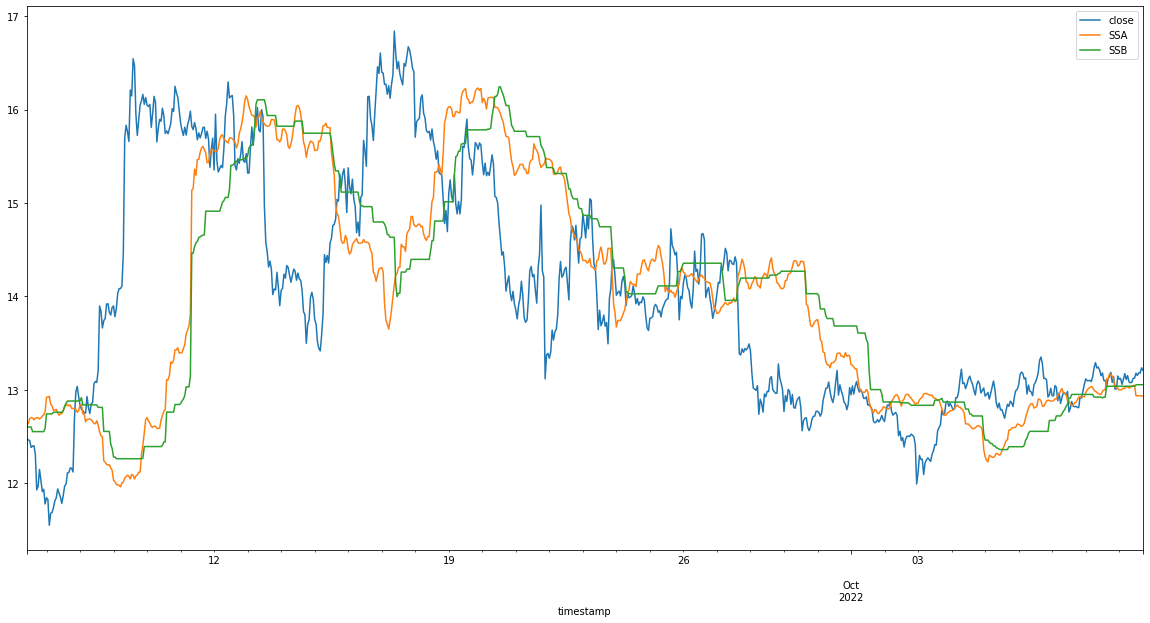

In [8]:
import pandas as pd
from binance.client import Client
import ta
import matplotlib

#import and download data
klinesT = Client().get_historical_klines("ATOMUSDT", Client.KLINE_INTERVAL_1HOUR, "01 October 2021")
df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])

del df['ignore']
del df['close_time']
del df['quote_av']
del df['trades']
del df['tb_base_av']
del df['tb_quote_av']

df['close'] = pd.to_numeric(df['close'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['open'] = pd.to_numeric(df['open'])

df = df.set_index(df['timestamp'])
df.index = pd.to_datetime(df.index, unit='ms')

del df['timestamp']

df['EMA28'] = ta.trend.ema_indicator(df['close'], 28)
df['EMA48'] = ta.trend.ema_indicator(df['close'], 48)
df['EMA50'] = ta.trend.ema_indicator(df['close'], 50)
#df['SMA7'] = ta.trend.sma_indicator(df['close'], 7)
#df['SMA25'] = ta.trend.sma_indicator(df['close'], 25)
df['STOCH_RSI'] = ta.momentum.stochrsi(df['close'])
df['TENKAN'] = ta.trend.ichimoku_conversion_line(df['high'],df['low'])
df['KIJUN'] = ta.trend.ichimoku_base_line(df['high'],df['low'])
df['SSA'] = ta.trend.ichimoku_a(df['high'],df['low'],3,38).shift(periods=48)
df['SSB'] = ta.trend.ichimoku_b(df['high'],df['low'],38,46).shift(periods=48)

print('Last price : ',df['close'].iloc[-1])
print('SSA[-1] = ',df['SSA'].iloc[-1])
print('SSB[-1] = ',df['SSB'].iloc[-1])
print('STOCH_RSI[-1] = ',df['STOCH_RSI'].iloc[-1])

df[['close','SSA','SSB']].iloc[-800:].plot(figsize=(20,10))


# Make backtest

In [ ]:
import numpy as np
df['Log returns'] = np.log(df['close']/df['close'].shift())
volatility = df['Log returns'].std()*252**.5
print('Volatility :', volatility)

0.19908224238366748


In [ ]:
usdt = 1000
coin = 0
lastIndex = df.first_valid_index()
lastBuyIndex = ""
dt = None
dt = pd.DataFrame(columns = ['date','position', 'reason', 'price', 'frais' ,'usdt', 'coins', 'wallet'])

for index, row in df.iterrows():
  #if df['SMA50'][lastIndex] > df['SMA200'][lastIndex] and usdt > 10:
  #if row['EMA28'] > row['EMA48'] and usdt > 10 and row['STOCH_RSI'] < 0.8:
  if row['close'] > row['SSA'] and row['close'] > row['SSB'] and usdt > 0 and row['STOCH_RSI'] < 0.8 :#and row['close']>row['EMA50']
    coin = usdt / row['close']
    price = row['close']
    fee = 0.0007 * coin
    coin = coin - fee
    usdt = 0
    wallet = coin * row['close']
    myrow = pd.DataFrame({'date':index,'position':'Buy','reason':'Buy Market','price':price,'frais':fee,'usdt':usdt,'coins':coin,'wallet':wallet},index=[0])
    dt = pd.concat([dt,myrow])
    lastBuyIndex = index
    print(f'{index} Tendance haussière') 
    #print("Buy ",coin," coins at", row['close'],'$ the', index)

  #if df['SMA50'][lastIndex] < df['SMA200'][lastIndex] and eth > 0.0001:
  #if row['EMA28'] < row['EMA48'] and coin > 0.0001 and row['STOCH_RSI'] > 0.2:
  elif (row['close'] < row['SSA'] and row['close'] < row['SSB']) and coin > 0 and row['STOCH_RSI'] > 0.2:
    #if row['close'] > df['close'][lastBuyIndex] : #or row['close'] > df['close'][lastIndex] :
      print(f'{index} Tendance baissière') 
      #print("Sell ",coin," coins at", row['close'],'$ the', index, ' last buy ',df['close'][lastBuyIndex])
      usdt = coin * row['close']
      price = row['close']
      fee = 0.0007 * usdt
      usdt = usdt - fee
      wallet = usdt
      coin = 0

      myrow = pd.DataFrame({'date':index,'position':'Sell','reason':'Sell Market','price':price,'frais':fee,'usdt':usdt,'coins':coin,'wallet':wallet},index=[0])
      dt = pd.concat([dt,myrow])

  lastIndex = index

2021-10-04 14:00:00 Tendance haussière
2021-10-05 20:00:00 Tendance baissière
2021-10-08 11:00:00 Tendance haussière
2021-10-10 02:00:00 Tendance baissière
2021-10-14 09:00:00 Tendance haussière
2021-10-19 00:00:00 Tendance baissière
2021-10-20 21:00:00 Tendance haussière
2021-10-24 13:00:00 Tendance baissière
2021-10-25 09:00:00 Tendance haussière
2021-10-27 10:00:00 Tendance baissière
2021-10-29 08:00:00 Tendance haussière
2021-10-30 15:00:00 Tendance baissière
2021-10-30 18:00:00 Tendance haussière
2021-10-31 06:00:00 Tendance baissière
2021-11-01 02:00:00 Tendance haussière
2021-11-09 13:00:00 Tendance baissière
2021-11-13 18:00:00 Tendance haussière
2021-11-16 04:00:00 Tendance baissière
2021-11-20 17:00:00 Tendance haussière
2021-11-23 22:00:00 Tendance baissière
2021-11-29 09:00:00 Tendance haussière
2021-12-04 07:00:00 Tendance baissière
2021-12-07 13:00:00 Tendance haussière
2021-12-08 04:00:00 Tendance baissière
2021-12-08 21:00:00 Tendance haussière
2021-12-09 13:00:00 Tenda

# Print results

Final results : 577.7104817352424
Profit and loss : -32.09477382526811
--- Plot ---


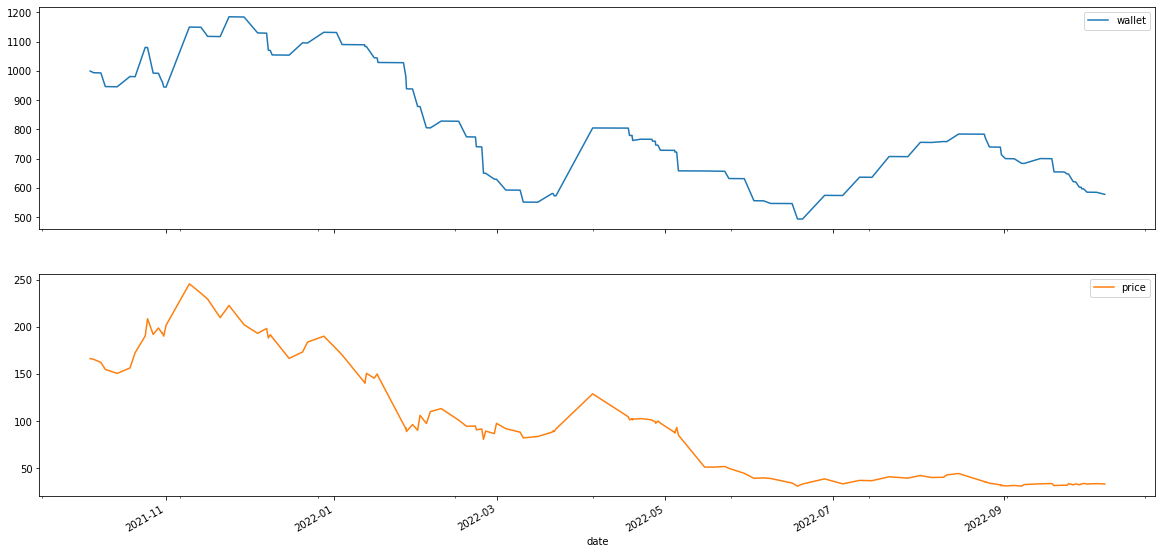

In [ ]:
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat'] = dt['wallet'].diff()
dt['resultat%'] = dt['wallet'].pct_change()*100
dt.loc[dt['position']=='Buy','resultat'] = None
dt.loc[dt['position']=='Buy','resultat%'] = None

print('Final results :', dt['wallet'].iloc[-1])
print('Profit and loss :',dt['resultat%'].sum())


dt[['wallet','price']].plot(subplots=True,figsize=(20,10))
print('--- Plot ---')